In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, normalize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from my_model import create_model_1, create_model_1_1, create_model_1_2, create_model_2, create_model_2_1
tf.__version__


'2.6.0'

In [2]:
train_df = pd.read_csv(os.path.join('data', 'unionTrain.csv'))
test_df = pd.read_csv(os.path.join('data', 'unionTest.csv'))
print(f"Length Train: {len(train_df)}")
print(f"Length Test: {len(test_df)}")

Length Train: 107
Length Test: 19


In [3]:
X_train, y_train = train_df.drop(['Severity', 'sequence_id'], axis=1), train_df['Severity']
X_test, y_test = test_df.drop(['Severity', 'sequence_id'], axis=1), test_df['Severity']

In [4]:
idx = 8
tm = X_train.iloc[idx][[f'{i}_0X' for i in range(50)]] # max = 854
print(f'Index:{idx}, Severity:{y_train[idx]}, {tm.to_list()}')

Index:8, Severity:2, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
def feature_engineering(df):
    return df
tmp_X_train = feature_engineering(X_train)
tmp_X_train.head()

,0_0X,0_0Y,0_1X,0_1Y,0_2X,0_2Y,0_3X,0_3Y,0_4X,0_4Y,...,853_20X,853_20Y,853_21X,853_21Y,853_22X,853_22Y,853_23X,853_23Y,853_24X,853_24Y
0,203.818390,137.074432,213.271698,120.394463,218.456604,128.786789,214.281204,138.171570,209.073471,139.232819,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,2.578170,21.342966,29.684607,82.876892,53.714298,149.624344,0.000000,0.000000,...,236.188980,71.378502,236.188980,71.378502,236.188980,71.378502,236.188980,71.378502,236.188980,71.378502
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,222.626373,125.631256,222.626373,125.631256,222.626373,125.631256,222.626373,125.631256,222.626373,125.631256
4,126.701424,108.963158,120.373978,85.994064,122.495720,96.498444,129.821487,105.855408,114.185593,106.893127,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
def get_scaler(scaler_name):
    if scaler_name == 'RobustScaler':
        scaler = RobustScaler()
    elif scaler_name == 'MinMaxScaler':
        scaler = MinMaxScaler()
    return scaler
scaler_name = 'RobustScaler'
# scaler_name = 'MinMaxScaler'
scaler = get_scaler(scaler_name)

In [7]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Max: {X_train.max()}, Min: {X_train.min()}")
def modify_X(x):
    result = x.copy()
    result = result.reshape(-1, 854, 50)
    return result
X_train_modified = modify_X(X_train)
X_test_modified = modify_X(X_test)
X_train_modified.shape, X_test_modified.shape

Max: 488.5626831054688, Min: -5.134825106291681


((107, 854, 50), (19, 854, 50))

In [8]:
# joblib.dump(scaler, os.path.join('saved_scaler', 'MinMaxScaler.pkl'))

In [9]:
def modify_y(df):
    result = pd.get_dummies(df)
    result = result.to_numpy()
    return result
y_train_modified = modify_y(y_train)
y_test_modified = modify_y(y_test)
y_train_modified.shape, y_test_modified.shape

((107, 2), (19, 2))

In [10]:
input_shape, n_output = (X_train_modified.shape[1], X_train_modified.shape[2]), y_train_modified.shape[1]
# model = create_model_1(input_shape, n_output)
# model = create_model_1_1(input_shape, n_output)
model = create_model_1_2(input_shape, n_output)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 854, 256)          183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 854, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 651,650
Trainable params: 651,650
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = Adam(learning_rate=1e-3)
model.compile(
                optimizer=optimizer,
                loss=CategoricalCrossentropy(),
                metrics=[
                    'accuracy'
                ]
              )

In [12]:
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss',
                                factor=0.5,
                                patience=4,
                                min_lr=1e-4
                              )
early_stopping = EarlyStopping(
                                monitor='loss',
                                patience=6
                              )

In [21]:
history = model.fit(X_train_modified, y_train_modified,
          batch_size=32,
          epochs=30,
          shuffle=True,
          validation_split=0.2,
          callbacks=[
              reduce_lr,
              early_stopping,
              ]
          )

Epoch 1/30
3/3 [==============================] - 21s 7s/step - loss: 0.1062 - accuracy: 0.9765 - val_loss: 0.6406 - val_accuracy: 0.7273
Epoch 2/30
3/3 [==============================] - 24s 9s/step - loss: 0.0931 - accuracy: 0.9882 - val_loss: 0.6674 - val_accuracy: 0.6818
Epoch 3/30
3/3 [==============================] - 32s 10s/step - loss: 0.0927 - accuracy: 0.9882 - val_loss: 0.6959 - val_accuracy: 0.6818
Epoch 4/30
3/3 [==============================] - 26s 9s/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 0.6910 - val_accuracy: 0.6818
Epoch 5/30
3/3 [==============================] - 27s 9s/step - loss: 0.0818 - accuracy: 0.9765 - val_loss: 0.7130 - val_accuracy: 0.6818
Epoch 6/30
3/3 [==============================] - 27s 9s/step - loss: 0.0759 - accuracy: 0.9882 - val_loss: 0.7068 - val_accuracy: 0.6818
Epoch 7/30
3/3 [==============================] - 20s 7s/step - loss: 0.0658 - accuracy: 0.9882 - val_loss: 0.6727 - val_accuracy: 0.6818
Epoch 8/30
3/3 [=================

In [22]:
# from datetime import datetime
# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# model.save(os.path.join("saved_models", f"trained_at_{current_time}_using_{scaler_name}.h5"))

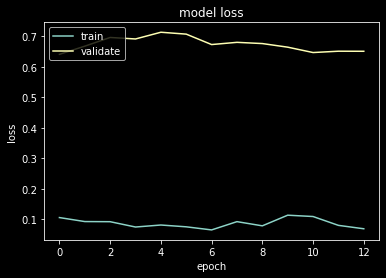

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

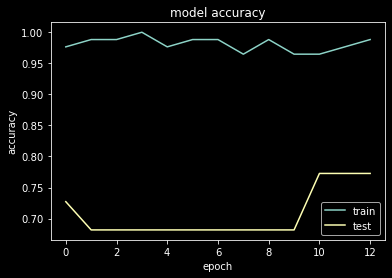

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [25]:
train_predict = model.predict(X_train_modified)
train_real_predict = np.argmax(train_predict, axis=1)+1
for i in range(len(y_train)):
    print(f"Index:{i}, Predict:{train_real_predict[i]}, Real:{y_train[i]}")

Index:0, Predict:1, Real:1
Index:1, Predict:2, Real:2
Index:2, Predict:2, Real:2
Index:3, Predict:2, Real:2
Index:4, Predict:1, Real:1
Index:5, Predict:2, Real:2
Index:6, Predict:2, Real:2
Index:7, Predict:1, Real:1
Index:8, Predict:2, Real:2
Index:9, Predict:2, Real:2
Index:10, Predict:2, Real:2
Index:11, Predict:1, Real:1
Index:12, Predict:2, Real:2
Index:13, Predict:2, Real:2
Index:14, Predict:2, Real:2
Index:15, Predict:1, Real:1
Index:16, Predict:1, Real:1
Index:17, Predict:1, Real:1
Index:18, Predict:2, Real:2
Index:19, Predict:1, Real:1
Index:20, Predict:1, Real:1
Index:21, Predict:2, Real:2
Index:22, Predict:2, Real:2
Index:23, Predict:1, Real:1
Index:24, Predict:1, Real:1
Index:25, Predict:1, Real:1
Index:26, Predict:2, Real:2
Index:27, Predict:2, Real:2
Index:28, Predict:1, Real:1
Index:29, Predict:1, Real:1
Index:30, Predict:1, Real:1
Index:31, Predict:2, Real:2
Index:32, Predict:1, Real:1
Index:33, Predict:2, Real:2
Index:34, Predict:2, Real:2
Index:35, Predict:2, Real:2
In

              precision    recall  f1-score   support

           1       0.91      1.00      0.95        51
           2       1.00      0.91      0.95        56

    accuracy                           0.95       107
   macro avg       0.96      0.96      0.95       107
weighted avg       0.96      0.95      0.95       107

---------------------------------------------------------


<AxesSubplot:>

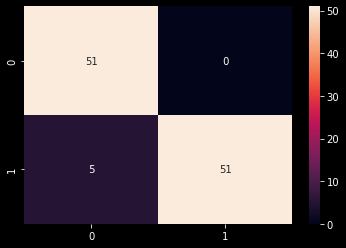

In [26]:
f1_train = f1_score(y_train, train_real_predict)
accuracy_train = accuracy_score(y_train, train_real_predict)
# print(f"f1: {f1_train}\naccuracy: {accuracy_train}")
print(classification_report(y_train, train_real_predict))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(y_train, train_real_predict),annot = True,fmt = '2.0f')

In [27]:
test_predict = model.predict(X_test_modified)
test_real_predict = np.argmax(test_predict, axis=1)+1
for i in range(len(y_test)):
    print(f"Index:{i}, Predict:{test_real_predict[i]}, Real:{y_test[i]}")

Index:0, Predict:2, Real:2
Index:1, Predict:2, Real:2
Index:2, Predict:2, Real:2
Index:3, Predict:2, Real:2
Index:4, Predict:2, Real:2
Index:5, Predict:2, Real:1
Index:6, Predict:2, Real:1
Index:7, Predict:1, Real:1
Index:8, Predict:1, Real:2
Index:9, Predict:1, Real:2
Index:10, Predict:2, Real:2
Index:11, Predict:2, Real:2
Index:12, Predict:1, Real:2
Index:13, Predict:2, Real:1
Index:14, Predict:2, Real:2
Index:15, Predict:1, Real:2
Index:16, Predict:2, Real:1
Index:17, Predict:2, Real:2
Index:18, Predict:2, Real:2


f1: 0.20000000000000004
accuracy: 0.5789473684210527
              precision    recall  f1-score   support

           1       0.20      0.20      0.20         5
           2       0.71      0.71      0.71        14

    accuracy                           0.58        19
   macro avg       0.46      0.46      0.46        19
weighted avg       0.58      0.58      0.58        19

---------------------------------------------------------



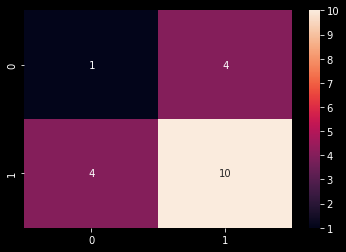

In [28]:
f1_test = f1_score(y_test, test_real_predict)
accuracy_test = accuracy_score(y_test, test_real_predict)
print(f"f1: {f1_test}\naccuracy: {accuracy_test}")
print(classification_report(y_test, test_real_predict))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(y_test, test_real_predict),annot = True,fmt = '2.0f')
print()